In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- 1. Setup and Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50 # Set a higher number, early stopping will likely trigger before this
PATIENCE = 5  # Number of epochs to wait for improvement before stopping



Using device: cuda


In [4]:
# --- 2. Data Loading and Preprocessing ---
# Define transformations
# ToTensor converts image to PyTorch tensor (scales pixel values to [0, 1])
# Normalize adjusts pixel values to have a specific mean and standard deviation
# These values are standard for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', # Directory to download/store data
                               train=True,
                               download=True,
                               transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 59.4kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]


In [5]:
# Download and load the validation/test data
# We'll use the standard MNIST test set as our validation set for early stopping
val_dataset = datasets.MNIST(root='./data',
                             train=False,
                             download=True,
                             transform=transform)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False) # No need to shuffle validation data

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Training dataset size: 60000
Validation dataset size: 10000
Number of training batches: 938
Number of validation batches: 157


In [6]:

# --- 3. Model Definition ---
class SimpleMNIST_NN(nn.Module):
    def __init__(self):
        super(SimpleMNIST_NN, self).__init__()
        # MNIST images are 28x28 pixels = 784
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128) # Input layer to first hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)      # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)       # Output layer (10 classes for digits 0-9)
        # No final activation here, CrossEntropyLoss will apply Softmax internally
        # If using NLLLoss, add nn.LogSoftmax(dim=1) here

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x) # Raw scores (logits)
        return x

model = SimpleMNIST_NN().to(device)
print("\nModel Architecture:")
print(model)




Model Architecture:
SimpleMNIST_NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
# --- 4. Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss - suitable for classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 5. Training Loop with Early Stopping ---
best_accuracy = 0.0
no_improvement = 0
best_model_path = "best_mnist_model.pth"

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



In [8]:
print("\nStarting Training...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data to device
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights

        # Calculate statistics
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

        # Optional: Print batch progress
        # if (batch_idx + 1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Disable gradient calculations during validation
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = 100. * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

    # --- Early Stopping Condition (as provided by user) ---
    if epoch_val_accuracy > best_accuracy:
        print(f"Validation accuracy improved ({best_accuracy:.2f}% -> {epoch_val_accuracy:.2f}%). Saving model...")
        best_accuracy = epoch_val_accuracy
        no_improvement = 0
        torch.save(model.state_dict(), best_model_path) # Save the best model state
    else:
        no_improvement += 1
        print(f"No improvement in validation accuracy for {no_improvement} epoch(s). Best was {best_accuracy:.2f}%.")
        if no_improvement >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break # Exit the training loop

print("\nTraining Finished.")




Starting Training...
Epoch [1/50] - Train Loss: 0.3488, Train Acc: 90.10% | Val Loss: 0.1723, Val Acc: 94.77%
Validation accuracy improved (0.00% -> 94.77%). Saving model...
Epoch [2/50] - Train Loss: 0.1419, Train Acc: 95.77% | Val Loss: 0.1240, Val Acc: 96.06%
Validation accuracy improved (94.77% -> 96.06%). Saving model...
Epoch [3/50] - Train Loss: 0.0988, Train Acc: 96.99% | Val Loss: 0.0947, Val Acc: 96.90%
Validation accuracy improved (96.06% -> 96.90%). Saving model...
Epoch [4/50] - Train Loss: 0.0749, Train Acc: 97.67% | Val Loss: 0.0859, Val Acc: 97.14%
Validation accuracy improved (96.90% -> 97.14%). Saving model...
Epoch [5/50] - Train Loss: 0.0581, Train Acc: 98.14% | Val Loss: 0.0797, Val Acc: 97.48%
Validation accuracy improved (97.14% -> 97.48%). Saving model...
Epoch [6/50] - Train Loss: 0.0481, Train Acc: 98.46% | Val Loss: 0.0826, Val Acc: 97.45%
No improvement in validation accuracy for 1 epoch(s). Best was 97.48%.
Epoch [7/50] - Train Loss: 0.0390, Train Acc: 98.

In [9]:
import os

# --- 6. Load the Best Model (Optional but good practice) ---
if os.path.exists(best_model_path):
    print(f"\nLoading best model state from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    model.eval() # Set to evaluation mode
    # You could run a final evaluation on the test set here if desired
else:
    print("Warning: Best model file not found. Plotting based on last epoch's model.")





Loading best model state from: best_mnist_model.pth


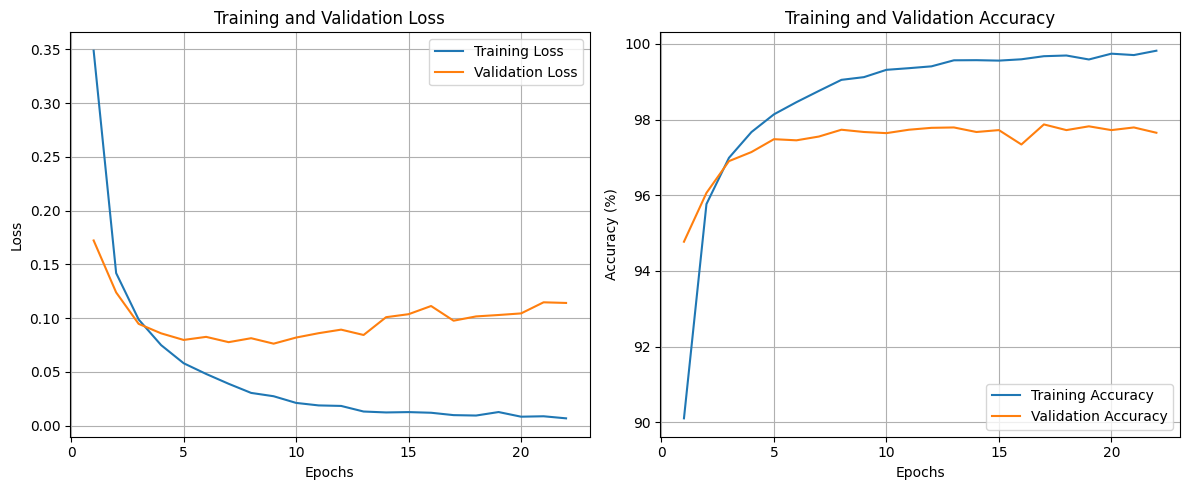


Best validation accuracy achieved: 97.87%


In [10]:
# --- 7. Plot Loss and Accuracy Curves ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest validation accuracy achieved: {best_accuracy:.2f}%")